In [1]:
from witch.core import model
from witch.utils import *
from witch.fitter import *
from witch.containers import Model
import witch.mapmaking as mm

import minkasi.tools.presets_by_source as pbs
import minkasi

from astropy.coordinates import Angle
import astropy.units as units

import yaml
import numpy as np
import os
import glob
import shutil

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

mpi4py imported
nproc:,  1


In [2]:

path = "/home/jorlo/dev/minkasi_jax/configs/MOOJ1142/MOOJ1142_SHOCK.yaml"
with open(path, "r") as file:
    cfg = yaml.safe_load(file)
if "models" not in cfg:
    cfg["models"] = {}
fit = True

In [3]:
cfg = load_config({}, path)
cfg["fit"] = cfg.get("fit", "model" in cfg)
cfg["sim"] = cfg.get("sim", False)
cfg["wnoise"] = cfg.get("wnoise", False)
cfg["map"] = cfg.get("map", True)
cfg["sub"] = cfg.get("sub", True)

cfg["sim"] = False

In [4]:
todroot = cfg["paths"]["tods"]
if not os.path.isabs(todroot):
    todroot = os.path.join(
        os.environ.get("MJ_TODROOT", os.environ["HOME"]), todroot
    )
tod_names = glob.glob(os.path.join(todroot, cfg["paths"]["glob"]))
bad_tod, _ = pbs.get_bad_tods(
    cfg["name"], ndo=cfg["paths"]["ndo"], odo=cfg["paths"]["odo"]
)
if "cut" in cfg["paths"]:
    bad_tod += cfg["paths"]["cut"]
tod_names = minkasi.tods.io.cut_blacklist(tod_names, bad_tod)
tod_names.sort()
ntods = cfg["minkasi"].get("ntods", None)
tod_names = tod_names[:ntods]
tod_names = tod_names[minkasi.myrank :: minkasi.nproc]
minkasi.barrier()  # Is this needed?

todvec = minkasi.tods.TodVec()
ntods = 60
for i, fname in enumerate(tod_names):
    if i > ntods: break
    dat = minkasi.tods.io.read_tod_from_fits(fname)
    minkasi.tods.processing.truncate_tod(dat)
    minkasi.tods.processing.downsample_tod(dat)
    minkasi.tods.processing.truncate_tod(dat)
    # figure out a guess at common mode and (assumed) linear detector drifts/offset
    # drifts/offsets are removed, which is important for mode finding.  CM is *not* removed.
    dd, pred2, cm = minkasi.tods.processing.fit_cm_plus_poly(
        dat["dat_calib"], cm_ord=3, full_out=True
    )
    dat["dat_calib"] = dd
    dat["pred2"] = pred2
    dat["cm"] = cm

    tod = minkasi.tods.Tod(dat)
    todvec.add_tod(tod)

deleted  32  bad files.
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  168 24708 168  on  /mnt/welch/MUSTANG/M2-TODs/MOOJ1142/Signal_TOD-AGBT18B_215_04-s34.fits with lims  175.60196424011508 175.78468546079125 15.366699613572672 15.544407475398064
truncating from  24708  to  24697
truncating from  2469  to  2465
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  167 24708 167  on  /mnt/welch/MUSTANG/M2-TODs/MOOJ1142/Signal_TOD-AGBT18B_215_04-s35.fits with lims  175.60159540989991 175.78423466830606 15.367317745692558 15.54445187162767
truncating from  24708  to  24697
truncating from  2469  to  2465
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > re

In [5]:
lims = todvec.lims()
pixsize = 2.0 / 3600 * np.pi / 180
skymap = minkasi.maps.SkyMap(lims, pixsize)


model = Model.from_cfg(cfg)
funs = [model.minkasi_helper]
params = np.array(model.pars)
npars = np.array([len(params)])
prior_vals = model.priors
priors = [None if prior is None else "flat" for prior in prior_vals]

# Deal with bowling and simming in TODs and setup noise
noise_class = eval(str(cfg["minkasi"]["noise"]["class"]))
noise_args = eval(str(cfg["minkasi"]["noise"]["args"]))
noise_kwargs = eval(str(cfg["minkasi"]["noise"]["kwargs"]))
bowl_str = process_tods(
    cfg, todvec, skymap, noise_class, noise_args, noise_kwargs, model
)

# Get output
outdir = get_outdir(cfg, bowl_str, model)

got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
Outputs can be found in /mnt/welch/USERS/jorlo/Reductions/MOOJ1142/ea10-shock-ps_gauss/dx_1-dy_1-r_1-theta-m500-dx_2-dy_2-amp_sh-kr-dx_g-dy_g-amp_g


In [6]:
# Make maps
npass = cfg["minkasi"]["npass"]
dograd = cfg["minkasi"]["dograd"]
# get the hit count map.  We use this as a preconditioner
# which helps small-scale convergence quite a bit.
hits = minkasi.mapmaking.make_hits(todvec, skymap)
naive = skymap.copy()
naive.clear()
for tod in todvec.tods:
    tmp = tod.info["dat_calib"].copy()
    u, s, v = np.linalg.svd(tmp, 0)
    pred = np.outer(u[:, 0], s[0] * v[0, :])
    tmp = tmp - pred
    naive.tod2map(tod, tmp)
naive.mpi_reduce()
naive.map[hits.map > 0] = naive.map[hits.map > 0] / hits.map[hits.map > 0]
if minkasi.myrank == 0:
    naive.write(os.path.join(outdir, "naive.fits"))
    hits.write(os.path.join(outdir, "hits.fits"))
hits_org = hits.copy()
hits.invert()

# setup the mapset.  In general this can have many things
# in addition to map(s) of the sky, but for now we'll just
# use a single skymap.
weightmap = minkasi.mapmaking.make_hits(todvec, skymap, do_weights=True)
mask = weightmap.map > 0
tmp = weightmap.map.copy()
tmp[mask] = 1.0 / np.sqrt(tmp[mask])
noisemap = weightmap.copy()
noisemap.map[:] = tmp
if minkasi.myrank == 0:
    noisemap.write(os.path.join(outdir, "noise.fits"))
    weightmap.write(os.path.join(outdir, "weights.fits"))

mapset = minkasi.maps.Mapset()
mapset.add_map(skymap)

# make A^T N^1 d.  TODs need to understand what to do with maps
# but maps don't necessarily need to understand what to do with TODs,
# hence putting make_rhs in the vector of TODs.
# Again, make_rhs is MPI-aware, so this should do the right thing
# if you run with many processes.
rhs = mapset.copy()
todvec.make_rhs(rhs)

# this is our starting guess.  Default to starting at 0,
# but you could start with a better guess if you have one.
x0 = rhs.copy()
x0.clear()

# preconditioner is 1/ hit count map.  helps a lot for
# convergence.
precon = mapset.copy()
precon.maps[0].map[:] = hits.map[:]

In [7]:
# run PCG

iters = [5, 25, 50]
mapset_out = minkasi.mapmaking.run_pcg_wprior(
    rhs,
    x0,
    todvec,
    None,
    precon,
    maxiter=50,
    outroot=os.path.join(outdir, "noprior"),
    save_iters=iters,
)


[0.03598189 0.27895093 0.04428554]
0 9049014189.99461 0.36215996742248535
[0.04347038 0.27228999 0.0472455 ]
1 232544704.37075174 1.2148264639376368e-05 0.3639509677886963 0.002345561981201172 0.36629652976989746 71.62331552071672
[0.04314852 0.27985191 0.04691172]
2 48857029.47334199 1.1321964904147534e-05 0.37073254585266113 0.0020210742950439453 0.3727536201477051 70.31315510767124
[0.04307246 0.27055287 0.04726291]
3 12408870.623334164 1.0032331854695953e-05 0.36171674728393555 0.00234222412109375 0.3640589714050293 72.06571217875623
[0.04336238 0.27735949 0.04385114]
4 4872412.014992695 1.1061581953352002e-05 0.3654296398162842 0.002063274383544922 0.3674929141998291 71.33349942031273
[0.0426929  0.26819825 0.04712319]
5 2122442.7371936007 1.2020828077378494e-05 0.35883212089538574 0.0025453567504882812 0.361377477645874 72.64504341181794
[0.04333568 0.27846169 0.04383683]
6 1113379.904578331 1.3660365024710785e-05 0.366485595703125 0.0021436214447021484 0.36862921714782715 71.127

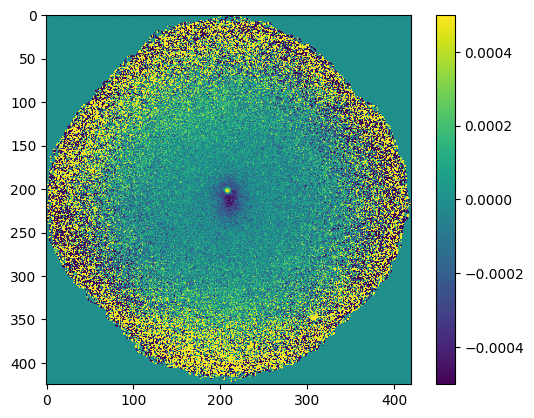

-0.0006919034952625736


In [8]:

cur_map = mapset_out.maps[0].map#naive.map #

lim = 5e-4
plt.imshow(cur_map, vmin = -lim, vmax = lim)
plt.colorbar()
plt.show()
print(np.amin(cur_map[200:300, 150:250]))


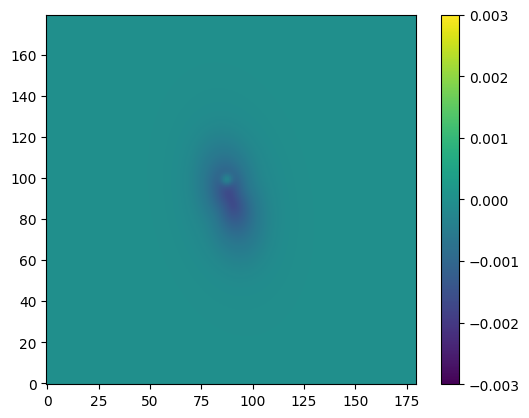

In [9]:
vis_model = model.model
lim = 3e-3

plt.imshow(vis_model, vmin = -lim, vmax = lim, origin="lower")
plt.colorbar()
plt.show()

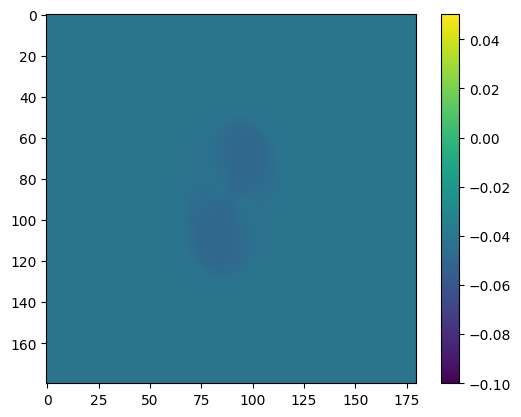

In [11]:
from witch.core import stage2_model

vis_model = stage2_model(model.xyz, 
                   tuple(model.n_struct),
                   model.dz,
                   model.beam,
                   *model.pars,
        )
lim = np.amin(vis_model)

plt.imshow(vis_model, vmin = -lim, vmax = 0)
plt.colorbar()
plt.show()